# RNN pour l'analyse de sentiments

Nous allons dans ce notebook faire une analyse de sentiments sur le jeu de données IMbd Reviews en utilisant les réseaux de neurones récurrents.

## Réseaux de neurones récurrents

Les réseaux de **neurones récurrents** ou (RNN), sont souvent utilisés pour analyser des séquences.
En effet, dans les réseaux de neurones généraux, un input est traité par un certain nombre de couches et un output est produit à la sortie, avec l'hypothèse que deux inputs successifs sont indépendants.
Cependant, cette hypothèse n'est pas correcte dans un certain nombre de scénarios. 
Par exemple, si on veut prédire le mot suivant dans une séquence, il est indispensable de considérer la dépendance des observations précédentes.
    
Dans notre cas, le modèle RNN prend une séquence de mots $X=\{x_1, ..., x_T\}$, une à la fois, et produit un état caché $h$, pour chaque mot.
On utilise le RNN en lui donnant le mot courant $x_t$ ainsi que l'état caché du mot précédent, $h_{t-1}$, pour produire l'état caché suivant, $h_t$.


$$h_t = \text{RNN}(x_t, h_{t-1})$$


Une fois que l'on a notre état caché final, $h_T$, obtenu après avoir donné le dernier mot de la séquence $x_T$ au modèle, on le donne à une couche $f$, (qui s'appelle également fully connected layer), pour recevoir notre sentiment prédit, $\hat{y} = f(h_T)$.

<center> <img src="./img/RNN.png" alt="drawing" width="700"/>
        
        
Cette illustration montre un exemple de phrase, avec le RNN prédisant 0, c'est-à-dire que le sentiment est négatif. Le RNN est représenté en orange et la couche fully connected layer est en gris. On utilise le même RNN pour chaque mot, c'est-à-dire qu'il a les mêmes paramètres. L'état initial caché $h_0$, est un tensor initialisé à zéro.

## Préparation des données

Dans ce notebook, on utilise la librairie torch et TorchText.

TorchText a une méthode `Field` qui sert à définir comment les données brutes doivent être traitées.

La méthode `TEXT` définit comment les commentaires doivent être traités, et `LABEL` comment les labels doivent être traités. 
Ces méthodes comportent plusieurs paramètres qui sont décrits dans la 
<a href="https://torchtext.readthedocs.io/en/latest/data.html#field">documentation</a>.

In [1]:
import pandas as pd
import torch
from torchtext import data
from torchtext import datasets
import random
# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True,lower=True, tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.5MB/s]


On sépare les données en données de train, de test et de validation.

In [2]:
import random

test_data, valid_data = test_data.split(random_state = random.seed(1234))

In [3]:
print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


On affiche un exemple d'un commentaire "tokénisé" avec le label correspondant.

In [4]:
print(vars(train_data.examples[1]))

{'text': ['watched', 'both', 'parts', 'twice', '.', 'enjoyed', 'the', 'story', 'and', 'enjoyed', 'seeing', 'an', 'older', 'patrick', 'swayze', 'as', 'the', 'hero', '.', 'he', 'was', 'very', 'believable', 'as', 'the', 'hunter', 'alan', 'quartermaine', 'and', 'certainly', 'bested', 'the', 'performance', 'of', 'richard', 'chamberlain', '.', 'i', 'do', 'admit', 'that', 'i', 'would', 'have', 'preferred', 'seeing', 'someone', 'else', 'as', 'the', '"', 'lady', 'in', 'distress', '"', '.', 'alison', 'doody', 'should', 'stick', 'with', 'modern', 'and', 'not', 'period', 'pieces', '.', 'she', 'did', "n't", 'have', 'the', 'look', 'of', 'the', 'woman', 'of', 'the', '1800', "'s", '.', 'the', 'rest', 'of', 'the', 'cast', 'were', 'terrific', 'and', 'followed', 'the', 'plotlines', 'very', 'well', '.', 'i', 'am', 'glad', 'to', 'see', 'that', 'the', 'actors', 'of', 'this', 'generation', 'are', 'not', 'afraid', 'to', 'try', 'on', 'different', 'characters', 'and', 'are', 'not', 'afraid', 'to', 'be', 'seen',

On construit le vocabulaire issu de l'échantillon train avec la méthode `build_vocab`.

In [5]:
TEXT.build_vocab(train_data)
print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 

Nombre de tokens unique dans le TEXT: 101520


Le vocabulaire est composé de 101513 mots. On le réduit en ne prennant que 25000 mots pour ne pas que la dimension de la matrice d'embedding soit trop grande.

In [6]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 
print(f"Nombre unique de LABEL: {len(LABEL.vocab)}")

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399670/400000 [00:24<00:00, 15454.76it/s]

Nombre de tokens unique dans le TEXT: 50002
Nombre unique de LABEL: 2


Les deux valeurs supplémentaires dans le vocabulaire du TEXT sont les tokens `<unk>` et `<pad>`. Si un mot de l'échantillon de validation ou de test n'est pas dans le vocabulaire, alors celui-ci est remplacé par `<unk>`. Le token `<pad>` est utilisé pour que les séquences d'un même batch soient de mêmes longueurs. 

On affiche ci-dessous les 20 mots les plus fréquents.

In [7]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 328822), (',', 275296), ('.', 236843), ('and', 162887), ('a', 161730), ('of', 145595), ('to', 135355), ('is', 110135), ('it', 93487), ('in', 92823), ('i', 82706), ('this', 73411), ('that', 73060), ('"', 63329), ("'s", 62109), ('-', 52863), ('/><br', 50935), ('was', 50375), ('as', 46161), ('for', 43937)]


Les valeurs du vocabulaire de LABEL sont 0 pour positif et 1 pour négatif.

In [8]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f5e56c38510>, {'neg': 0, 'pos': 1})


La dernière étape de la préparation des données consiste à créer les itérateurs. Nous les parcourons dans la boucle d'apprentissage / d'évaluation, et ils retournent un batch à chaque itération.

On utilise `BucketIterator` qui est un itérateur qui renverra un batch de séquences de mêmes longueurs grâce au padding.

In [9]:
# utilisation du GPU si possible 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device ='cpu'
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort = False)

## Construction du modèle

Le modèle RNN utilisé se compose des couches suivantes : 

- _embedding_ : utilisé pour transformer notre vecteur one hot encoder (dont la plupart des éléments sont des 0) en un vecteur embedding dense (dense car la dimensionnalité est beaucoup plus petite et tous les éléments sont des nombres réels). De plus, les mots qui ont un impact similaire sur le sentiment de la revue sont mappés de manière rapprochée dans cet espace vectoriel dense.
- _RNN_ : prend le vecteur dense et le précédent état caché $h_{t-1}$, et calcule l'état caché suivant $h_t$.
- _linéaire_ : prend le dernier état caché, le met dans un couche fully connected $f(h_T)$ qui le transfome en output prédit.


Par ailleurs, le modèle considéré est bidirectionnel, il peut être représenté comme ceci.


<center> <img src="./img/birnn.png" alt="drawing" width="600"/>


En plus d'avoir un RNN traitant les mots de la phrase du premier au dernier (un RNN forward), nous avons un deuxième RNN traitant les mots de la phrase du dernier au premier (un RNN backward). Au pas de temps $t$, le RNN forward traite le mot $ x_t $, et le RNN backward traite le mot $ x_ {T-t + 1}$

Chaque batch, `text` est un tensor de dimension _**[taille séquence, taille batch]**_. C'est un batch de commentaires, dont les mots sont convertis en représentation one-hot encoder. PyTorch stocke  un vecteur one-hot comme sa valeur d'index.

Le batch de l'input est ensuite passé à travers la couche embedding pour obtenir une représentation de vecteur dense de nos commentaires.
`embedded` est un tensor de taille _**[taille séquence, taille batch, dim embedding]**_.

`embedded`est ensuite introduit dans la couche RNN. Dans certains frameworks, vous devez alimenter l'état caché initial, $h_0$, dans le RNN, cependant dans PyTorch, si aucun état caché initial n'est passé comme argument, il prend par défaut un tenseur de valeurs zéros.

The RNN retourne 2 tenseurs, `output` de taille _**[taille séquence, taille batch, dim état caché*2]**_ et `hidden` de taille _**[num direction, taille batch, dim état caché]**_.

`output` est la concaténation de l'état caché de chaque pas de temps. Comme nous voulons les états cachés avant et arrière de la couche finale (supérieure), nous obtenons les deux couches cachées supérieures de la première dimension, hidden [-2,:,:] et hidden [-1,:,:], et les concaténons ensemble ( _**[taille batch, dim état caché*2]**_ ) avant de les transmettre à la couche linéaire, pour produire une prédiction.

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, bidirectional, dropout):
  
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim) 
        self.rnn = nn.RNN(embedding_dim, hidden_dim, bidirectional=bidirectional)   
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text):

        embedded = self.dropout(self.embedding(text)) 
        output, hidden = self.rnn(embedded) 
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        return self.fc(hidden)


On crée alors notre modèle. Les paramètres sont les suivants :

 - La dimension de l'input est la taille du vocabulaire. 
 - La dimension de l'embedding est la taille des vecteurs denses. Elle est généralement de 50 à 250, mais elle dépend de la taille du vocabulaire.
 - La dimension de hidden est la dimension des états cachés. Elle vaut généralement 100 à 500, mais dépend de la taille du vocabulaire, des vecteurs denses et la compléxité de la tâche. 
 - La dimension de l'output est le nombre de classes, ici, la valeur de l'output est entre 0 et 1 et donc est de dimension 1 car l'output est un scalaire.



In [11]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1
BIDIRECTIONAL = True
DROPOUT = 0.6
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BIDIRECTIONAL, DROPOUT)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 5,040,801 paramètres à entraîner


## Entraîner le modèle

On utilise l'optimiseur Adam.

In [13]:
import torch.optim as optim

def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-3, eps=1e-5, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

On définit ensuite la fonction de perte qui est ici la _binary cross entropy with logits_. 

In [14]:
criterion = nn.BCEWithLogitsLoss()

En utilisant `.to`, nous pouvons placer le modèle et le critère sur le GPU (si nous en avons un).

In [15]:
model = model.to(device)
criterion = criterion.to(device)

100%|█████████▉| 399670/400000 [00:40<00:00, 15454.76it/s]

La fonction criterion calcule la perte, cependant nous devons écrire notre fonction pour calculer l'accuracy.

 - Accuracy : 
$$accuracy = \frac{TP+TN}{TP+TN+FP+FN}\,,$$
 
avec $TP$ : vrais positifs, $TN$ : vrais négatifs, $FP$ : faux positifs, $FN$ : faux négatifs.

In [16]:
def binary_accuracy(preds, y):
    """
    Retourne l'accuracy par batch
    """
    #arrondi la prédiction à l'entier le plus proche
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


La fonction `train` itère sur tous les exemples, un batch à la fois.

`model.train()`est utilisé pour mettre le modèle en "mode entraînement", qui active _dropout_ et _batch normalization_, qui ne sont pas utilisés ici.

Pour chaque batch, on met à zéro le gradient. Chaque paramètre dans un modèle a un attribut `grad` qui stocke le gradient calculé par `criterion`. PyTorch ne met pas à zéro les gradients automatiquement.

Nous introduisons ensuite le batch de phrases, `batch.text`, dans le modèle. Le `squeeze` est nécessaire car les prédictions sont initialement de taille _**[taille batch, 1]**_, et nous devons supprimer la dimension de taille 1 car PyTorch s'attend à ce que les prédictions entrées dans notre fonction de critère soient de taille _**[taille batch]**_.
La perte et la précision sont ensuite calculées à l'aide de nos prédictions et des labels, `batch.label`, la perte étant moyennée sur toutes les séquences du batch.

Nous calculons le gradient de chaque paramètre avec `loss.backward ()`, puis mettons à jour les paramètres en utilisant les gradients et l'algorithme d'optimisation avec `optimizer.step ()`.

Enfin, nous retournons la perte et l'accuracy moyennés sur toute l'époque. 


In [17]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
  
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
               
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
   
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

La fonction `evaluate` est similaire à` train`, avec quelques modifications car on ne veut pas mettre à jour les paramètres lors de l'évaluation.

`model.eval ()` met le modèle en "mode d'évaluation", ceci désactive _dropout_ et _batch normalization_.

Aucun gradient n'est calculé sur les opérations PyTorch à l'intérieur du bloc `with no_grad ()`. Cela réduit l'utilisation de la mémoire et accélère le calcul.

Le reste de la fonction est identique à `train`, avec la suppression de` optimizer.zero_grad () `,` loss.backward () `et` optimizer.step () `, car nous ne mettons pas à jour les paramètres du modèle lors de l'évaluation.

In [18]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
   
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model.forward(batch.text).squeeze(1) 
            loss = criterion(predictions, batch.label)    

            acc = binary_accuracy(predictions, batch.label)

            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Nous entraînons ensuite le modèle sur plusieurs époques, une époque étant un passage complet à travers toutes les séquences dans les ensembles d'apprentissage et de validation.

À chaque époque, si la perte de validation est la meilleure que nous ayons vue jusqu'à présent, nous enregistrerons les paramètres du modèle, puis une fois l'entraînement terminé, nous utiliserons ce modèle sur l'ensemble de test.

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

tloss = []
tacc = []
vloss = []
vacc = []
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc) 
    scheduler.step()
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)  
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 7s
	Train Loss: 0.705 | Train Acc: 51.70%
	 Val. Loss: 0.679 |  Val. Acc: 57.46%
Epoch: 02 | Epoch Time: 2m 6s
	Train Loss: 0.692 | Train Acc: 53.49%
	 Val. Loss: 0.677 |  Val. Acc: 58.14%
Epoch: 03 | Epoch Time: 2m 6s
	Train Loss: 0.688 | Train Acc: 54.91%
	 Val. Loss: 0.697 |  Val. Acc: 50.07%
Epoch: 04 | Epoch Time: 2m 7s
	Train Loss: 0.689 | Train Acc: 54.74%
	 Val. Loss: 0.702 |  Val. Acc: 50.39%
Epoch: 05 | Epoch Time: 2m 5s
	Train Loss: 0.686 | Train Acc: 56.03%
	 Val. Loss: 0.691 |  Val. Acc: 53.32%
Epoch: 06 | Epoch Time: 2m 6s
	Train Loss: 0.682 | Train Acc: 56.32%
	 Val. Loss: 0.682 |  Val. Acc: 55.98%
Epoch: 07 | Epoch Time: 2m 6s
	Train Loss: 0.679 | Train Acc: 57.50%
	 Val. Loss: 0.659 |  Val. Acc: 61.09%
Epoch: 08 | Epoch Time: 2m 6s
	Train Loss: 0.673 | Train Acc: 58.44%
	 Val. Loss: 0.693 |  Val. Acc: 51.09%
Epoch: 09 | Epoch Time: 2m 5s
	Train Loss: 0.690 | Train Acc: 54.14%
	 Val. Loss: 0.676 |  Val. Acc: 57.39%
Epoch: 10 | Epoch Time: 2m 6

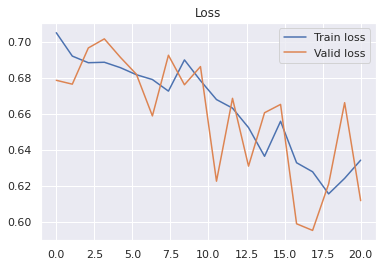

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

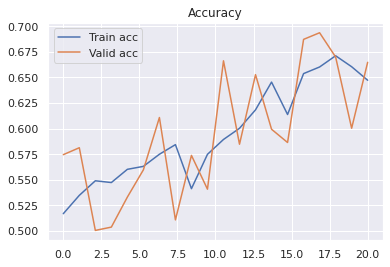

In [21]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

Les hyperparamètres choisis sont : 


|Embedding dim|Hidden dim|Learning rate|
|-------------|----------|-------------|
|100           | 100      | 1e-4        |


## Tester le modèle

In [22]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.601 | Test Acc: 69.36%


### Inférence

Notre fonction predict_sentiment fait plusieurs choses:

 - définit le modèle en mode d'évaluation
 - tokenise la phrase, c'est-à-dire la divise d'une chaîne brute en une liste de jetons
 - indexe les jetons en les convertissant en leur représentation entière à partir de notre vocabulaire
 - obtient la longueur de notre séquence
 - convertit les index, qui sont une liste Python en un tenseur PyTorch
 - ajouter une dimension de lot en relâchant
 - convertit la longueur en un tenseur
 - écrase la prédiction de sortie d'un nombre réel compris entre 0 et 1 avec la fonction sigmoïde
 - convertit le tenseur contenant une valeur unique en un entier avec la méthode item ()

Nous nous attendons à ce que les avis avec un sentiment négatif renvoient une valeur proche de 0 et les avis positifs renvoient une valeur proche de 1.

In [23]:
import spacy
nlp = spacy.load('en')
import torch.nn.functional as F
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor))
    return 1 - prediction.item()

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor)
    out = F.softmax(prediction, 1)
    if (torch.argmax(out[0]) == 0):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")


In [24]:
predict_sentiment(model, "This film is terrible")

Sentiment: Positive


In [25]:
predict_sentiment(model, "This film is great")

Sentiment: Positive


In [26]:
predict_sentiment(model, "This film is not good")

Sentiment: Positive


On remarque que ce modèle nous donne de mauvais résultats. En utilisant un modèle plus avancé on obtiendrait de meilleurs résultats.

## Réference : 

 - https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
